In [117]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from utils.rff import *
from typing import Optional

from PIL import Image
import numpy as np
from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import regex as re
import seaborn as sns

DATA_DIR = "./data"

In [48]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [118]:
def load_dat_file(path, sep=",", y_pos=-1, x_transform=None, y_transform=None):
    
    x_data = []
    y_data = []

    if x_transform is None:
        def x_transform(x):
            return x

    if y_transform is None:
        def y_transform(y):
            return y

    with open(path, "r") as file:
        for line in file:
            if "@" in line:
                continue
            line = line.replace('\n', '')
            elements = str2list(line, sep)
            if y_pos is not None:
                y_data.append(y_transform(elements.pop(y_pos)))
            # print(elements)
            x_data.append(x_transform(elements))
    return x_data, y_data

def str2list(string, sep=","):
    return string.split(sep)

def australian_transform_x(x):
    isnumber = re.compile(r'\d+(?:,\d*)?')
    return [float(ele) if isnumber.search(ele) else ele for ele in x]

def australian_transform_y(y):
    return int(y)

def balance_transform_x(x):
    return [float(ele) for ele in x]

def balance_transform_y(y):
    if y == " B":
        return 0
    elif y == " R":
        return 1
    elif y == " L":
        return 2

def magic_transform_x(x):
    return [float(ele) for ele in x]

def magic_transform_y(y):
    if y == "g":
        return 0
    elif y == "h":
        return 1

def monk_transform_x(x):
    return [float(ele) for ele in x]

def monk_transform_y(y):
    return int(y)

def sonar_transform_x(x):
    return [float(ele) for ele in x]

def sonar_transform_y(y):
    if y == " R":
        return 0
    elif y == " M":
        return 1

def spambase_transform_x(x):
    return [float(ele) for ele in x]

def spambase_transform_y(y):
    return int(y)

def titanic_transform_x(x):
    return [float(ele) for ele in x]

def titanic_transform_y(y):
    if y=="-1.0":
        return 0
    elif y=="1.0":
        return 1

def CNAE_transform_x(x):
    return [float(ele) for ele in x]

def CNAE_transform_y(y):
    return int(y)

def covertype_transform_x(x):
    return [float(ele) for ele in x]

def covertype_transform_y(y):
    return int(y)

def madelon_transform_x(x):
    return [float(ele) for ele in x[:-1]]

def madelon_transform_y(y):
    assert len(y) == 1
    if y[0] == "-1":
        return 0
    elif y[0] == "1":
        return 1

In [119]:
class BaseDataset(Dataset):
    def __init__(self, x: list, y: list):
        self.x = torch.Tensor(x)
        self.y = torch.Tensor(y).long()
                
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class MLRepositoryDatasetGenerator():

    """FOR FUTURE IMPROVEMNT: BUILD A CLASS/FUNC THAT AUTOMATICALLY CREATES TEST/TRAIN SET ON DISK INSTEAD OF IN MEMORY TO IMPROVE EFFICIENCY."""

    def __init__(self, name: str, test_size=0.2, seed=42) -> None:
        self._load_dataset(name)
        self._instantiate_train_test(test_size, seed)

    def __call__(self, mode: str):
        if mode == "train":
            return BaseDataset(self.train_x, self.train_y)
        elif mode == "test":
            return BaseDataset(self.test_x, self.test_y)
        else:
            raise ValueError(f"Either 'train' or 'test' can be passed as valid modes. Got '{mode}' instead")
    
    def _instantiate_train_test(self, test_size, seed):
        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(self.x, self.y, test_size=test_size, random_state=seed)
        del self.x, self.y

    def _load_dataset(self, name: str):
        if name == "australian":
            self.x, self.y = load_dat_file(DATA_DIR + "/spambase/spambase.dat", x_transform=spambase_transform_x, y_transform=spambase_transform_y)
        elif name == "balance":
            self.x, self.y = load_dat_file(DATA_DIR + "/balance/balance.dat", x_transform=balance_transform_x, y_transform=balance_transform_y)
        elif name == "magic":
            self.x, self.y = load_dat_file(DATA_DIR + "/magic/magic.dat", x_transform=magic_transform_x, y_transform=magic_transform_y)
        elif name == "monk-2":
            self.x, self.y = load_dat_file(DATA_DIR + "/monk-2/monk-2.dat", x_transform=monk_transform_x, y_transform=monk_transform_y)
        elif name == "sonar":
            self.x, self.y = load_dat_file(DATA_DIR + "/sonar/sonar.dat", x_transform=sonar_transform_x, y_transform=sonar_transform_y)
        elif name == "titanic":
            self.x, self.y = load_dat_file(DATA_DIR + "/titanic/titanic.dat", x_transform=titanic_transform_x, y_transform=titanic_transform_y)
        elif name == "spambase":
            self.x, self.y = load_dat_file(DATA_DIR + "/spambase/spambase.dat", x_transform=spambase_transform_x, y_transform=spambase_transform_y)
        elif name == "CNAE-9":
            self.x, self.y = load_dat_file(DATA_DIR + "/CNAE-9/CNAE-9.data", y_pos=0, x_transform=CNAE_transform_x, y_transform=CNAE_transform_y)
        elif name == "covertype":
            self.x, self.y = load_dat_file(DATA_DIR + "/covertype/covtype.data", x_transform=covertype_transform_x, y_transform=covertype_transform_y)
        elif name == "madelon":
            self.x, _ = load_dat_file(DATA_DIR + "/madelon/madelon_train.data", y_pos=None, x_transform=madelon_transform_x, sep=" ")
            self.y, _ = load_dat_file(DATA_DIR + "/madelon/madelon_train.labels", y_pos=None, x_transform=madelon_transform_y)
        else:
            raise ValueError(f"The dataset {name} has not been implemented yet or does not exist")

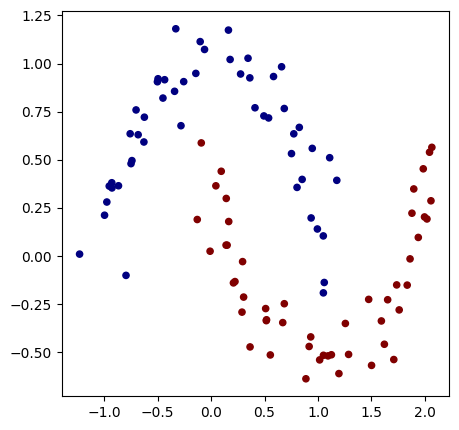

In [76]:
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [77]:
def all_exist(avalue, bvalue):
    return all(any(i in j for j in bvalue) for i in avalue)

class Mehrkanoon(nn.Module):
    def __init__(self, input_size: int, layer_shapes: dict, sigma: list):
        super(Mehrkanoon, self).__init__()

        self.flatten = nn.Flatten()
        keys = list(layer_shapes.keys())
        if all_exist(["h3", "h4", "s"], keys):
            self.mehrkanoon = nn.Sequential(
                nn.Linear(input_size, layer_shapes['h1']),
                RandomFourierFeatureLayer(layer_shapes['h1'], layer_shapes['h2'], sigma=sigma[0]),
                nn.Linear(layer_shapes['h2'], layer_shapes['h3']),
                RandomFourierFeatureLayer(layer_shapes['h3'], layer_shapes['h4'], sigma=sigma[1]),
                nn.Linear(layer_shapes['h4'], layer_shapes['s'])

            )
        elif all_exist(["h1", "h2", "s"], keys):           
            self.mehrkanoon = nn.Sequential(
                nn.Linear(input_size, layer_shapes['h1']),
                RandomFourierFeatureLayer(layer_shapes['h1'], layer_shapes['h2'], sigma=sigma[0]),
                nn.Linear(layer_shapes['h2'], layer_shapes['s'])        
            )
        elif "s" in keys:
            raise ValueError(f"")
        else:
            raise ValueError(f"")

    def forward(self, x):
        x = self.flatten(x)
        x = self.mehrkanoon(x)
        return x

In [106]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_history = []
    accuracy_history = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            loss_history.append(loss)
            accuracy_history.append(correct/len(X))
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return np.mean(np.array(loss_history)), np.mean(np.array(accuracy_history))
    


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct



In [120]:
batch_size = 20
epochs = 50
learning_rate = 1e-3

DatasetGenerator = MLRepositoryDatasetGenerator("balance")
training_data = DatasetGenerator('train')
test_data = DatasetGenerator('test')

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

model = Mehrkanoon(4, {'h1': 300, 'h2': 400, 's': 10}, sigma=[0.8, 0.7])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [122]:
for (x, y) in train_dataloader:
    print(x)
    break

tensor([[5., 3., 5., 3.],
        [5., 1., 5., 3.],
        [1., 1., 2., 2.],
        [1., 5., 3., 2.],
        [1., 5., 5., 4.],
        [5., 2., 2., 2.],
        [5., 3., 1., 1.],
        [5., 2., 5., 4.],
        [1., 5., 2., 3.],
        [4., 5., 1., 4.],
        [3., 4., 4., 2.],
        [4., 4., 3., 4.],
        [4., 3., 5., 2.],
        [3., 4., 1., 2.],
        [5., 5., 5., 1.],
        [2., 3., 4., 4.],
        [5., 2., 1., 2.],
        [1., 2., 4., 4.],
        [1., 4., 1., 2.],
        [5., 5., 1., 3.]])


In [108]:
class ModelTrainer():

    def __init__(self, model, train_data: type[DataLoader], 
                              test_data: type[DataLoader], 
                              loss_fn, optimizer, batch_size, epochs, learning_rate) -> None:
        self.model = model
        self.train_data = train_data
        self.test_data = test_data
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.current_epoch = 0
        self._fitted = False

        self.history = {'train_loss': [],
                        'test_loss': [],
                        'train_accuracy': [],
                        'test_accuracy': []}
    
    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs
        for t in range(epochs):
            self.current_epoch =+ 1
            print(f"Epoch {self.current_epoch}\n-------------------------------")
            train_loss, train_accuracy = train_loop(self.train_data, self.model, self.loss_fn, self.optimizer)
            test_loss, test_accuracy = test_loop(self.test_data, self.model, self.loss_fn)
            self.history['train_loss'].append(train_loss)
            self.history['train_accuracy'].append(train_accuracy)
            self.history['test_loss'].append(test_loss)
            self.history['test_accuracy'].append(test_accuracy)
        print("Done!")
        self._fitted = True

    def plot(self, metric):
        




array([1, 2])

Epoch 1
-------------------------------
loss: 2.335884  [   20/  500]
Test Error: 
 Accuracy: 12.0%, Avg loss: 2.329069 

Epoch 2
-------------------------------
loss: 2.245772  [   20/  500]
Test Error: 
 Accuracy: 10.4%, Avg loss: 2.342534 

Epoch 3
-------------------------------
loss: 2.184896  [   20/  500]
Test Error: 
 Accuracy: 12.0%, Avg loss: 2.356139 

Epoch 4
-------------------------------
loss: 2.129685  [   20/  500]
Test Error: 
 Accuracy: 12.0%, Avg loss: 2.367096 

Epoch 5
-------------------------------
loss: 2.078501  [   20/  500]
Test Error: 
 Accuracy: 12.0%, Avg loss: 2.373991 

Epoch 6
-------------------------------
loss: 2.031690  [   20/  500]
Test Error: 
 Accuracy: 12.0%, Avg loss: 2.376062 

Epoch 7
-------------------------------
loss: 1.988466  [   20/  500]
Test Error: 
 Accuracy: 13.6%, Avg loss: 2.373574 

Epoch 8
-------------------------------
loss: 1.947264  [   20/  500]
Test Error: 
 Accuracy: 14.4%, Avg loss: 2.367199 

Epoch 9
----------------

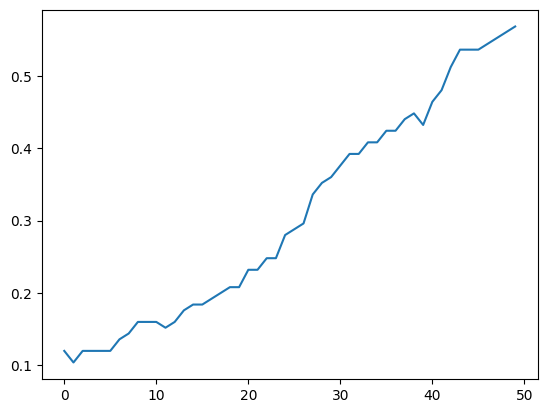

In [112]:
plt.plot(range(epochs), history['test_accuracy'])

In [37]:
for p in model.parameters():
    print(f"Shape: {p.shape}")
    print(f"Mean: {p.mean()}")
    print(f"Std {p.std()}")
    print("\n")

Shape: torch.Size([300, 784])
Mean: -0.00011821065709227696
Std 0.019961919635534286


Shape: torch.Size([300])
Mean: -0.001687744865193963
Std 0.03606632724404335


Shape: torch.Size([300, 400])
Mean: 0.003979723434895277
Std 0.8021396398544312


Shape: torch.Size([10, 400])
Mean: 4.207890378893353e-05
Std 0.054839447140693665


Shape: torch.Size([10])
Mean: 0.0027744420804083347
Std 0.06873872131109238




In [12]:
t = Mehrkanoon(784, layer_shapes={'h1':10, 'h2':20, 's':1}, sigma=[0.2])


In [73]:
model(training_data[0][0])

tensor([[ 0.1138,  0.4518, -0.0327, -0.1349,  0.0069,  0.0297,  0.1432,  0.1796,
         -0.7170,  0.3154]], grad_fn=<AddmmBackward0>)

In [78]:
nn.Softmax(dim=1)(model(training_data[0][0]))

tensor([[0.1039, 0.1457, 0.0898, 0.0811, 0.0934, 0.0956, 0.1070, 0.1110, 0.0453,
         0.1272]], grad_fn=<SoftmaxBackward0>)

In [60]:
for i, item in enumerate(train_dataloader):
    print(item)

RuntimeError: stack expects each tensor to be equal size, but got [100, 2] at entry 0 and [100] at entry 1